# **Geochemical composition uncertainties**

During the interviews conducted with the tephrochronology community (described in Martínez Fontaine et al., *in preparation*), one repeated need was being able to assess if the geochemical analyses performed in different laboratories are comparable or not. 

At present, this question is answered by geochemists by analyzing geostandards with *known* composition, along with the *unknown* samples. These geostandards correspond to specific materials (e.g. rocks, volcanic glass) for which their chemical composition is *known* and ideally *certified* (e.g. [Jochum et al., 2006](https://doi.org/0.1029/2005GC001060), [2011](https://doi.org/10.1111/j.1751-908X.2012.00221.x), [2016](https://doi.org/10.1111/j.1751-908X.2015.00392.x)). The samples and geostandards are analyzed together in *batches* or *measurement runs*, indicated in the BOOM dataset under the attribute "MeasurementRun", which links both files in the dataset: BOOMDataset.csv and MeasurementRuns.csv.

Two kinds of metrics are more routinely calculated to assess how comparable the geochemical analyses are, which are based on the geochemical composition of the geostandards analyzed during each measurement run:

-	**Accuracy** (1). Refers to how close the analyzed value is to the *true* value. To estimate the accuracy of an analysis, the average analyzed value of each element of each geostandard is compared to the certified values. Values closer to one are more accurate. Because different geostandards (which represent the geochemical diversity of the *unknown* samples), can be analyzed in one mesurement run, more than one accuracy for each analyzed element is estimated. Then, the accuracy will be the lower accuracy calculated.

$$
     accuracy_{element_i, geostandard_j} = \frac{AnalyzedValue_{element_i, geostandard_j}}{CertifiedValue_{element_i,geostandard_j}}
$$

-	**Precision** (2). Refers to the expected dispersion of the analyzed values. As with the accuracy, as many precisions as geostandards analyzed in each batch, for each analyzed element, are estimated. Ideally, the dispersion of the analyses is published as 1SD of each analyzed element, for each geostandard, for each measurement run. It is important to note, however, that the different analyzed elements can have very different concentrations and that will have an effect in the estimated precisions. For example, in the BOOM dataset, $SiO_{2}$ generally has concentrations of tens of wt.%, whereas MnO generally has concentrations of less than 1 wt.%. Because of this, the precision of the differen elements will be very different, e.g. around 0.1% for SiO2, and around 0.001% for MnO.  Thus, in order to being able to compare the precision of the analyses of different elements, the relative standard deviation (RSD) for each element is calculated.

$$
     RSD_{element_i, geostandard_j} = \frac{1SD_{element_i,geostandard_j}}{MeanAnalyzedValue_{element_i,geostandard_j}}*100
$$

    

# Load BOOM dataset

In [78]:
import pandas as pd
import requests
from io import StringIO 

#Download the dataset from the ESPRI server as .csv 
url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase.csv"
s=requests.get(url).text
BOOM = pd.read_csv(StringIO(s), encoding="latin1", low_memory=False)

#in case the ESPRI server is down:
#BOOM = pd.read_csv("../assets/Data/BOOMDataset.csv", encoding = 'UTF-8', low_memory =False )

print('\033[1m'+ 'Samples analyzed for geochemical composition:'+ '\033[0m')
print(len(BOOM[BOOM['TypeOfRegister']!='Organic matter']))

#filter sample observations for which the geostandard information is not included in the BOOM dataset
BOOM_with_geostandards = BOOM.dropna(subset = ['MeasurementRun']).copy()
BOOM_with_geostandards.loc[:,'MeasurementRun'] = BOOM_with_geostandards.loc[:,'MeasurementRun'].astype('str')

print("")
print('\033[1m'+ 'Samples including measurement runs information:'+ '\033[0m')
print(len(BOOM_with_geostandards))

Samples analyzed for geochemical composition:
16355

Samples including measurement runs information:
10891


In [79]:
#some of the samples have been analyzed twice, first for major element and then for trace elements. In order to treat this data
#  we will separate them in two different samples.
muestras_dobles = 0
for ms in ['AllowayMay2014, 31-oct-15','19-Abr-13, AllowayMay2014','DelCarlo2018EMP, DelCarlo2018LAICP-MS']:
    if ',' in ms:
        print(ms)
        print(ms.partition(', ')[0])
        print(ms.partition(', ')[2])
        temp_major =  BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun==ms]
        temp_major.MeasurementRun = ms.partition(', ')[0]
        
        temp_trace = BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun==ms]
        temp_trace.MeasurementRun = ms.partition(', ')[2]
        
        BOOM_with_geostandards = BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun!=ms]
        
        BOOM_with_geostandards = BOOM_with_geostandards.append(temp_major)
        BOOM_with_geostandards = BOOM_with_geostandards.append(temp_trace)
        
        muestras_dobles = muestras_dobles+len(temp_trace.MeasurementRun)
        
        print(" ")

print('muestras dobles: ' + str(muestras_dobles))

AllowayMay2014, 31-oct-15
AllowayMay2014
31-oct-15
 
19-Abr-13, AllowayMay2014
19-Abr-13
AllowayMay2014
 
DelCarlo2018EMP, DelCarlo2018LAICP-MS
DelCarlo2018EMP
DelCarlo2018LAICP-MS
 
muestras dobles: 184


In [80]:
# Load data of geostandards analyzed in each run from the MeasurementRuns file: ID of the geostandard (e.g. ATHO-G, ML3B-G), 
#     the average analyzed value for each analyzed element, its standard deviation (SD), 
#     the relative standard deviation (RSD) and the number of analyses performed for of each geostandard (n).

standard_url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase_Standards.csv"
s=requests.get(standard_url).text
BOOM_geostandards = pd.read_csv(StringIO(s), encoding="latin1")
BOOM_geostandards.loc[:,'MeasurementRun'] = BOOM_geostandards.loc[:,'MeasurementRun'].astype('str')

#in case the ESPRI server is down:
#BOOM_geostandards = pd.read_csv("../assets/Data/MeasurementRuns.csv", encoding = 'UTF-8', low_memory =False )
#BOOM_geostandards.loc[:,'MeasurementRun'] = BOOM_geostandards.loc[:,'MeasurementRun'].astype('str')

print('\033[1m'+ 'Number of sample observations analyzed for geochemical composition, for which the average, std and n analyzed for each element, for each geostandard analyzed along with the samples, are included in the BOOM Dataset:'+ '\033[0m')
print(len(BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun.isin(BOOM_geostandards[BOOM_geostandards.n!= 'Not reported'].MeasurementRun.unique().tolist())])-muestras_dobles)
print(' ')

print('\033[1m'+ 'Number of sample observations analyzed for geochemical composition, for which only the average of the geostandard are included in the BOOM Dataset:'+ '\033[0m')
print(len(BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun.isin(BOOM_geostandards[BOOM_geostandards.n== 'Not reported'].MeasurementRun.unique().tolist())]))

Number of sample observations analyzed for geochemical composition, for which the average, std and n analyzed for each element, for each geostandard analyzed along with the samples, are included in the BOOM Dataset:
10438
 
Number of sample observations analyzed for geochemical composition, for which only the average of the geostandard are included in the BOOM Dataset:
453


Unfortunately, not all the geostandards reported in the literature contained in the BOOM Dataset, have certified values. In those cases, it is not possible to estimate the precision and accuracy of the analyses, as there is no reference to compare to.

Thus, in order to estimate the precision and the accuracy of the analyses, it is necesary to filter the sample observations for which the geostandards analyzed along with the samples have no certified values.

The geostandards with certified values in the dataset correspond to geostandards certified by  [Jochum et al., 2006](https://doi.org/0.1029/2005GC001060), [2011](https://doi.org/10.1111/j.1751-908X.2012.00221.x), 2015, [2016](https://doi.org/10.1111/j.1751-908X.2015.00392.x), or by the providers of the standards (e.g. OREAS).
The certifed values can be accessed a:

- [Georem](http://georem.mpch-mainz.gwdg.de/)
- [OREAS184](https://www.oreas.com/crm/oreas-184/)
- [OREAS700](https://www.oreas.com/crm/oreas-700/)
- [SY-4](https://www.nrcan.gc.ca/our-natural-resources/minerals-mining/mining-resources/sy-4-diorite-gneiss/8025)
- [NCS DC70009 (GBW07241)](http://www.ncsstandard.com/upload/file/201606088392.pdf)


# Load geostandards certified values

In [97]:
#Load the geostandards reference values and filter the ones with certified values.
 
BOOM_geostandards_ref = pd.read_csv('../assets/Data/Standards_Reference.csv', encoding = 'UTF-8', low_memory =False)
BOOM_geostandards_ref = BOOM_geostandards_ref[BOOM_geostandards_ref.StandardID.isin([
    'AGV-2',
    'ATHO-G',
    'BCR-2',
    'BHVO-1','BHVO-2',
    'BIR-1',
    'GOR132-G','GOR128-G',  
    'JA-1','JA-2',
    'KL2-G',    
    'ML3B-G',
    'NIST SRM 610',
    'OREAS184','OREAS700',        
    'StHs6/80-G',
    'SY-4',
    'T1-G',
    'W-2',
    ])].copy()

#Print certified geostandards in the dataset
temp1 = BOOM_geostandards_ref.StandardID.unique().tolist()
print('\033[1m'+ 'Certified geostandards included in the BOOM Dataset'+ '\033[0m')
print(temp1)

#print MeasurementRuns with certified geostandards
temp2 = BOOM_geostandards[BOOM_geostandards.Standard.isin(temp1)].MeasurementRun.unique().tolist()
print(" ")
print('\033[1m'+ 'Measurement Runs with certified geostandards'+ '\033[0m')
print(temp2)

print(" ")
print('\033[1m'+ 'Number of sample observations analyzed along with certified geostandards'+ '\033[0m')
temp3 = BOOM_geostandards[BOOM_geostandards.Standard.isin(temp1)]
temp4 = temp3[((temp3.SiO2!=-1)&(temp3.SD_SiO2!=-1))|((temp3.Rb!=-1)&(temp3.SD_Rb!=-1))].MeasurementRun.unique().tolist()
print(len(BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun.isin(temp4)].MeasurementRun)-muestras_dobles)

print(" ")
print('\033[1m'+ 'Number of sample observations analyzed along with certified geostandards, where the mean, std and number of analyses is included in the BOOM TephraDataSet'+ '\033[0m')
temp5 = temp3[temp3.n!='Not reported'].MeasurementRun.unique()
print(len(BOOM_with_geostandards[BOOM_with_geostandards.MeasurementRun.isin(temp5)].MeasurementRun)-muestras_dobles)

Certified geostandards included in the BOOM Dataset
['AGV-2', 'ATHO-G', 'BCR-2', 'BHVO-1', 'BHVO-2', 'BIR-1', 'GOR128-G', 'GOR132-G', 'JA-1', 'JA-2', 'KL2-G', 'ML3B-G', 'NIST SRM 610', 'OREAS184', 'OREAS700', 'StHs6/80-G', 'SY-4', 'T1-G', 'W-2']
 
Measurement Runs with certified geostandards
['11112', '21112', '40413', '40917', '12-Sep-14', '8-May-15', '31-oct-15', '50318', '50413', '50717', '060912', '60912', '61112', '070912', '70912', '80713', '80917', '81112', '100415', '100713', '100912', '120713', '130415', '131213', '140214', '190115', '190314', '190816', '200115', '200314', '200318', '210114', '210314', '211013', '220114', '220115', '221013', '230115', '230714', '231017', '240117', '240714', '250117', '250714', '260117', '270118', '270217', '270918', '280217', '290918', '16-abr-13', '19-Abr-13', '23-Ago-12', 'AllowayMay2014', 'AllowaySOLICPMS2015', 'Brahm2018', 'Carel2011Dec', 'Carel2011Sept', 'Geoffroy2018Major10um', 'Geoffroy2018MajorSpot', 'Geoffroy2018Trace', 'Geoffroy2018T

# 1 Estimate accuracy

In [83]:
import sys
sys.path.insert(1, '../Scripts')
from functions import estimating_accuracy, plot_accuracy_MeasurementRun

# Estimating accuracy, following ecuation (1)
BOOM_geostandards_accuracy = estimating_accuracy(temp3[temp3.n!='Not reported'],BOOM_geostandards_ref)

Now that we have estimated the accuracy for each measurement run (with suitable information), we can visualize the results.

In [84]:
# Plotting accuracy by each Measurement Run. In order for the notebook to be rendered in git, 
#    we will not run the following line, which plots the accuracy for the 79 different measurement runs.
#    But users can do it locally.
#plot_accuracy_MeasurementRun(BOOM_geostandards_accuracy,save=False)

Additionally, if the user wants to check the accuracy for some specific Measurement Run, they can do the following. In the example we want to plot runs 11112 and 21112 as ['11112','21112']. As many specific runs can be added, for example if we want to additionally print Rawson2016, we would write: ['11112','21112','Rawson2016].

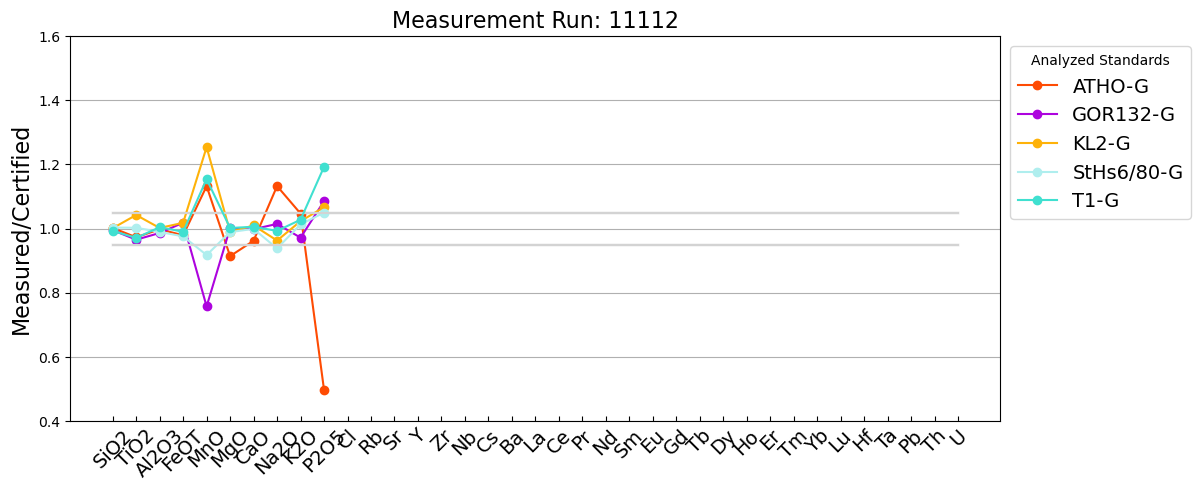

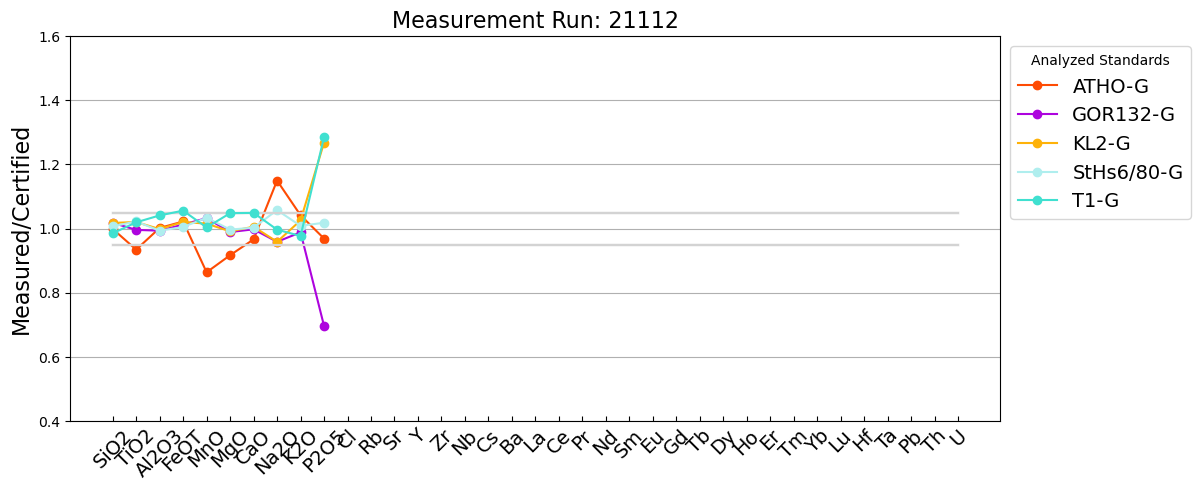

In [85]:
plot_accuracy_MeasurementRun(BOOM_geostandards_accuracy[BOOM_geostandards_accuracy.MeasurementRun.isin(['11112','21112'])])

In [86]:
BOOM_geostandards_accuracy[BOOM_geostandards_accuracy.MeasurementRun.isin(['11112'])]

,MeasurementRun,Standard,SiO2,TiO2,Al2O3,MnO,MgO,Fe2O3T,FeOT,CaO,...,Ho,Er,Tm,Yb,Lu,Hf,Ta,Pb,Th,U
0,11112,ATHO-G,1.002029,0.972843,0.997680,1.132311,0.914078,NaN,0.979144,0.962074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11112,GOR132-G,0.995180,0.965278,0.986273,0.757305,1.001525,NaN,1.018245,0.998098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11112,KL2-G,1.001152,1.042285,1.001889,1.253939,0.989486,NaN,1.017921,1.009693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11112,StHs6/80-G,1.003163,1.002525,0.989496,0.917434,0.988985,NaN,0.975721,0.999086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11112,T1-G,0.992934,0.970894,1.004170,1.154134,1.001820,NaN,0.990151,1.005528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the latter examples, for measurement run 11112, lower accuracies are observed for MnO, Na2O and P2O5, whereas all other elements are within 1±0.05. 

Users might alternatively want to plot the accuracy for a specific sample. In the following example we want to check the accuracy of the geochemical analysis of sample 'T-44'.

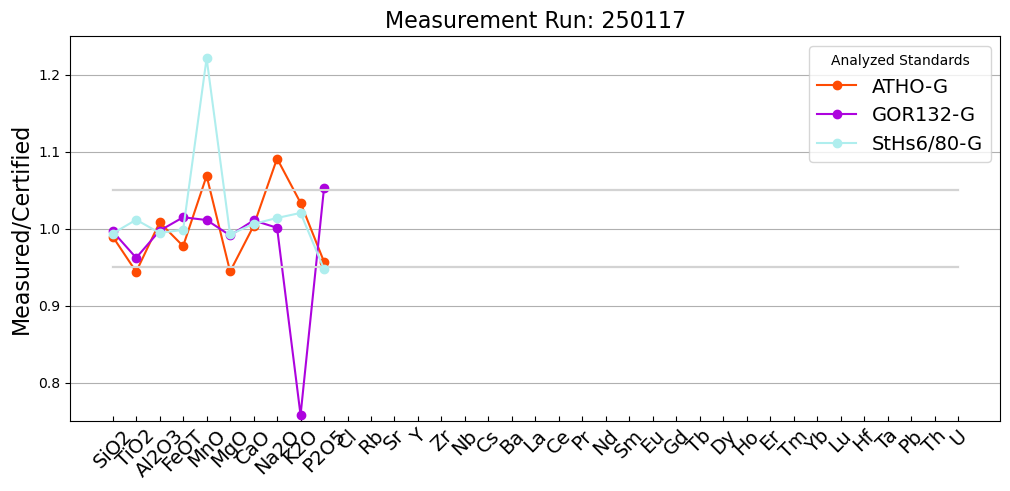

In [87]:
plot_accuracy_MeasurementRun(BOOM_geostandards_accuracy[BOOM_geostandards_accuracy.MeasurementRun.isin(BOOM_with_geostandards[BOOM_with_geostandards.SampleID == 'T-44'].MeasurementRun.unique())],
             ymin=0.75,ymax=1.25)

We can observe that for sample T-44, the elements analyzed with lower accuracies are MnO, Na2O and K20. Additionally, it is visible that a given element might be analyzed with different accuracies for different geostandards. In particular, K2O is more or less accurate for StGs6/80-G, whereas it is less accurate for GOR132-G.

It is important to note that if no certified secondary standards information is available, nothing will be plotted:

In [88]:
plot_accuracy_MeasurementRun(BOOM_geostandards_accuracy[BOOM_geostandards_accuracy.MeasurementRun.isin(BOOM_with_geostandards[BOOM_with_geostandards.SampleID == 'JK193'].MeasurementRun.unique())])

Finally, we can visualize the accuracy of all the measurement runs in the BOOM Dataset to have an idea of the overall accuracy of the analyses. Geostandards with less than 3 analyses are plotted as dots, whereas for geostandards with mor ethan three analyses in the dataset, the standard deviation from the mean is plotted.

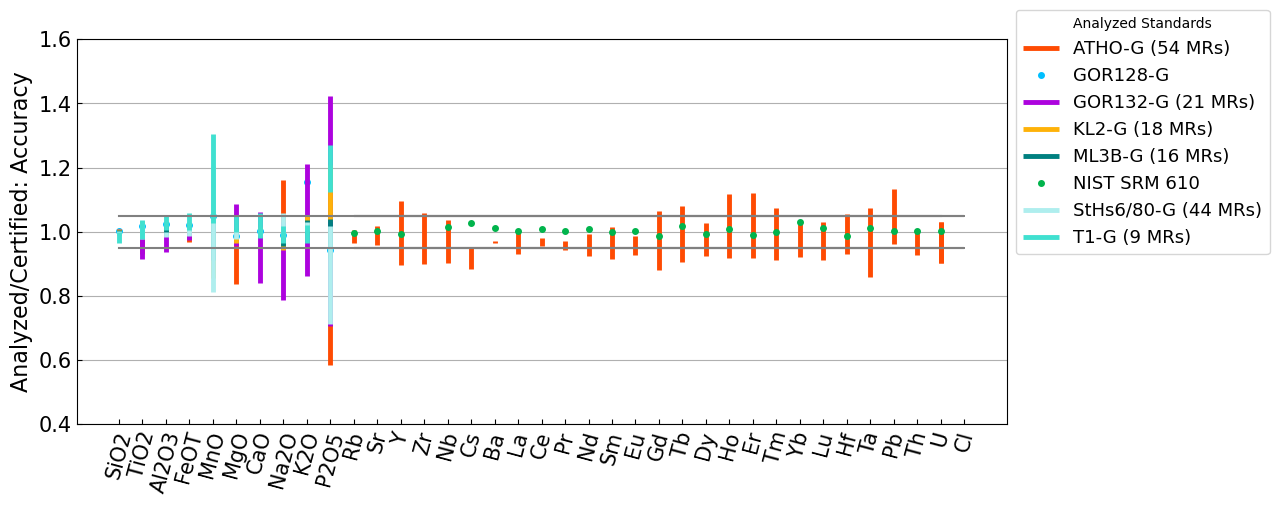

In [89]:
from functions import estimating_accuracy, plot_accuracy_BOOM

plot_accuracy_BOOM(BOOM_geostandards_accuracy)

In [90]:
print('\033[1m'+ 'Accuracies Summary'+ '\033[0m')
print(" ")

for elemento in ['SiO2','TiO2','Al2O3','MnO','MgO','FeOT','CaO','Na2O','K2O','P2O5','Cl',
                             'Rb','Sr','Y','Zr','Nb','Cs','Ba','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb',
                             'Dy','Ho','Er','Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb', 'Th', 'U']:
    print('\033[1m'+ elemento + '\033[0m')
    print('Min: {}, Max: {}, Mean: {}, STD: {}'.format(BOOM_geostandards_accuracy[elemento].min(),BOOM_geostandards_accuracy[elemento].max(),BOOM_geostandards_accuracy[elemento].mean(),BOOM_geostandards_accuracy[elemento].std()))
    print(" ")      

Accuracies Summary
 
SiO2
Min: 0.9581672354948806, Max: 1.0179736263736263, Mean: 0.9965602621258407, STD: 0.008464868948738493
 
TiO2
Min: 0.8737291176470589, Max: 1.0749019607843138, Mean: 0.9879590816284671, STD: 0.03927144901111368
 
Al2O3
Min: 0.897009090909091, Max: 1.0559931771929825, Mean: 0.9986743304342217, STD: 0.020877888833926474
 
MnO
Min: 0.6603773584905661, Max: 1.6421052631578947, Mean: 1.0087660429172844, STD: 0.1458824619484626
 
MgO
Min: 0.679611650485437, Max: 1.1592857142857143, Mean: 0.9724061520367219, STD: 0.06472355907088656
 
FeOT
Min: 0.9113149847094801, Max: 1.0573408385093168, Mean: 1.0017839494270866, STD: 0.02174868322448768
 
CaO
Min: 0.7215095337278107, Max: 1.0567136154929577, Mean: 0.9930633276299101, STD: 0.04502142336711726
 
Na2O
Min: 0.6371084337349399, Max: 1.1949599999999998, Mean: 1.009579405010362, STD: 0.08889193112468537
 
K2O
Min: 0.7577922077922078, Max: 1.4545454545454546, Mean: 1.026904888512935, STD: 0.07162104859729512
 
P2O5
Min: 0.1

# 2 Plot precision

In the case of precision, no additional calculations are needed, we can simply plot the relative standard deviation, already included in the MeasurementRuns.csv file. If the users want to check the precision of some specific Measurement run they can do the following, adding as many specific runs they want.

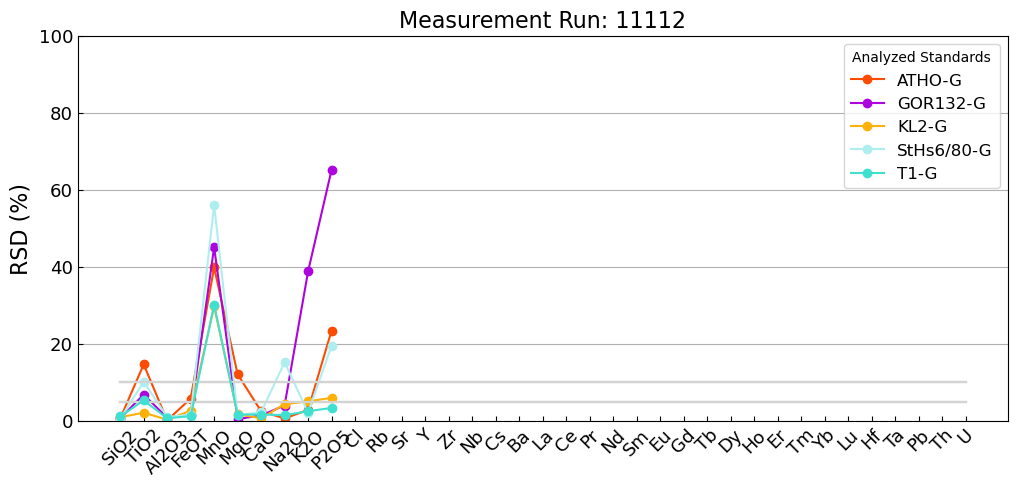

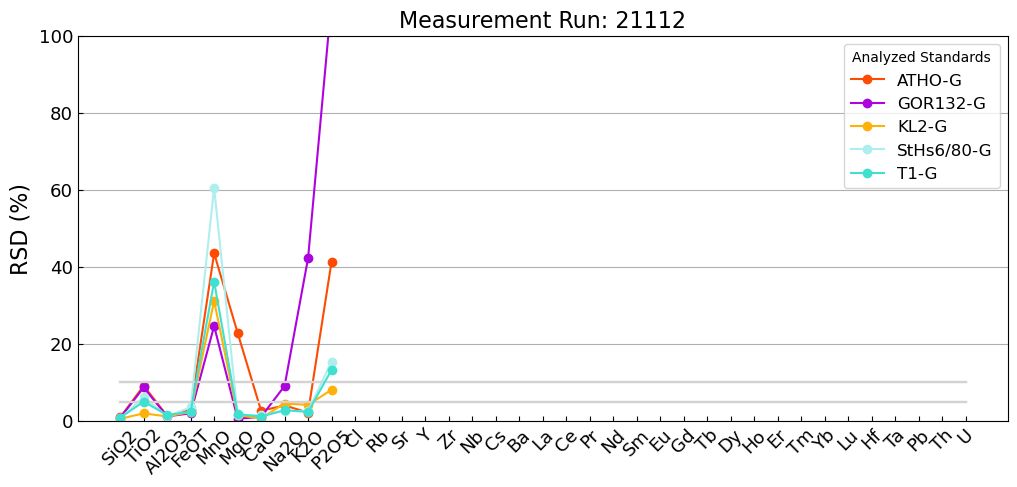

In [91]:
from functions import plot_RSD_MeasurementRun

plot_RSD_MeasurementRun(BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(['11112','21112'])])

In [92]:
BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(['11112'])][['Standard','RSD_TiO2']]

,Standard,RSD_TiO2
0,ATHO-G,14.65
1,GOR132-G,6.80
2,KL2-G,2.11
3,StHs6/80-G,10.14
4,T1-G,5.29


For measurement run 11112, lower precisions are observed for MnO, K2O and P2O5.

If the users want to check the precision for a specific sample (e.g. JK193) they can do  the following.

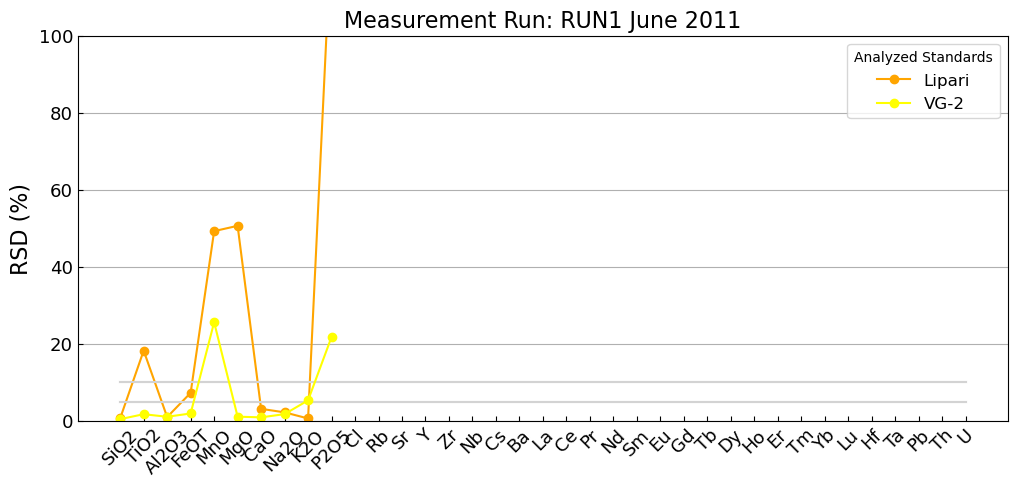

In [93]:
plot_RSD_MeasurementRun(BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(BOOM_with_geostandards[BOOM_with_geostandards.SampleID == 'JK193'].MeasurementRun.unique())],ymin=0,ymax=120)

The precision of all the measurement runs can also be visualized, to have an idea of the overall precision of the analyses.

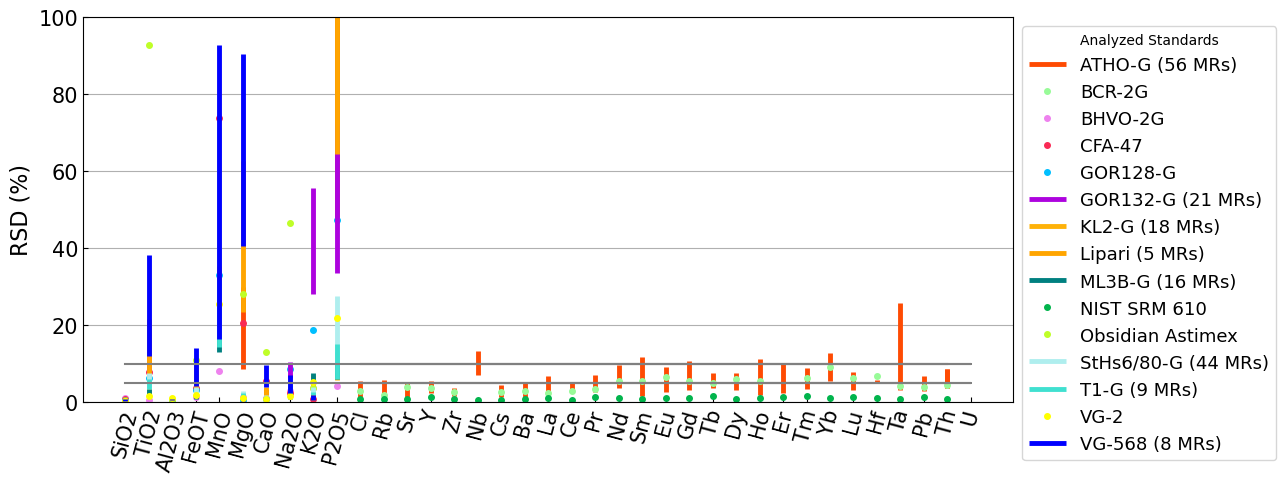

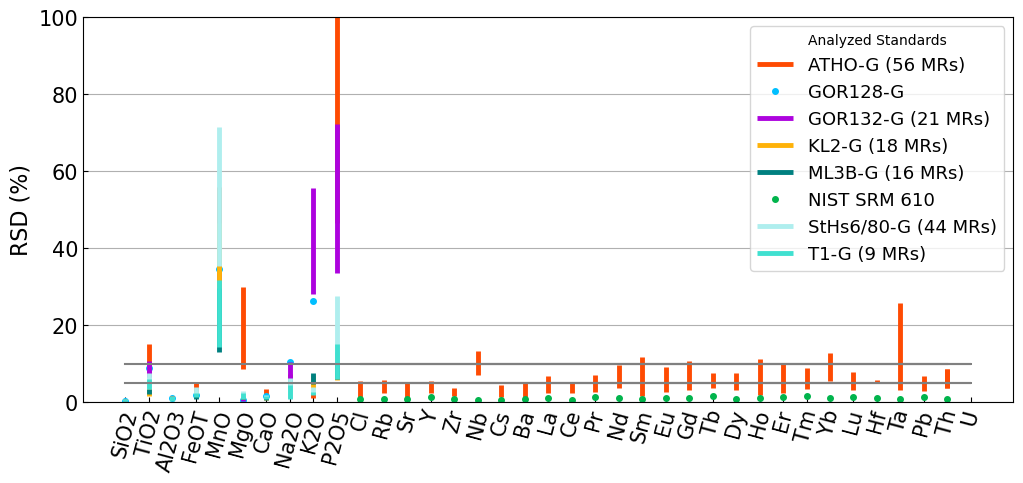

In [94]:
from functions import plot_RSD_BOOM

plot_RSD_BOOM(BOOM_geostandards[BOOM_geostandards.Standard!='?'] ,ymin = 0, ymax= 100)
plot_RSD_BOOM(temp3[temp3.n!='Not reported'] ,ymin = 0, ymax= 100)

In [98]:
print('\033[1m'+ 'Precision Summary'+ '\033[0m')
print(" ")

for elemento in ['SiO2','TiO2','Al2O3','MnO','MgO','FeOT','CaO','Na2O','K2O','P2O5','Cl',
                             'Rb','Sr','Y','Zr','Nb','Cs','Ba','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb',
                             'Dy','Ho','Er','Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb', 'Th', 'U']:
    print('\033[1m'+ elemento + '\033[0m')
    print('Min: {}, Max: {}, Mean: {}, STD: {}'.format(BOOM_geostandards['RSD_'+elemento].min(),BOOM_geostandards['RSD_'+elemento].max(),BOOM_geostandards['RSD_'+elemento].mean(),BOOM_geostandards['RSD_'+elemento].std()))
    print(" ")  

Precision Summary
 
SiO2
Min: 0.09, Max: 1.54, Mean: 0.5669945355191258, STD: 0.30043418209680006
 
TiO2
Min: 0.21, Max: 92.67, Mean: 8.494863387978143, STD: 8.95897621321359
 
Al2O3
Min: 0.11, Max: 2.83, Mean: 0.9659016393442624, STD: 0.41899688050917344
 
MnO
Min: 0.0, Max: 141.42, Mean: 38.52284153005465, STD: 21.65342423018428
 
MgO
Min: 0.21, Max: 100.0, Mean: 10.71349726775956, STD: 17.396626672146734
 
FeOT
Min: 0.57, Max: 18.52, Mean: 3.233497267759563, STD: 2.260204407935671
 
CaO
Min: 0.37, Max: 13.07, Mean: 1.9379781420765025, STD: 1.717778644659165
 
Na2O
Min: 0.45, Max: 46.56, Mean: 4.835846994535517, STD: 4.163046514771725
 
K2O
Min: 0.15, Max: 74.82, Mean: 7.81770491803279, STD: 13.38096142919451
 
P2O5
Min: 3.34, Max: 206.17, Mean: 42.3394011976048, STD: 41.14169757262512
 
Cl
Min: nan, Max: nan, Mean: nan, STD: nan
 
Rb
Min: 0.7168, Max: 5.3004, Mean: 2.688275, STD: 1.7274176372757772
 
Sr
Min: 0.7432, Max: 5.4545, Mean: 2.8684250000000002, STD: 1.8179838257570629
 
Y
